In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Data visualization

In [2]:
data = pd.read_csv('Nat_Gas.csv')

In [3]:
data

,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84
8,6/30/21,10.00
9,7/31/21,10.10


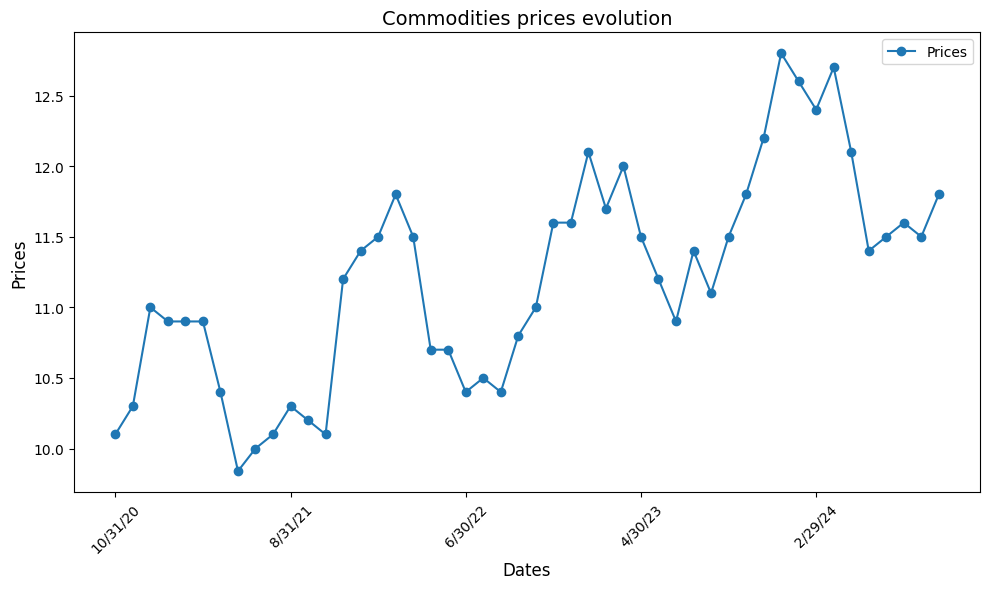

In [4]:
plt.figure(figsize=(10, 6)) 
data.plot(x="Dates", y="Prices", kind="line", marker="o", ax=plt.gca())

plt.title("Commodities prices evolution", fontsize=14)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Prices", fontsize=12)
plt.xticks(rotation=45)  
plt.tight_layout()      
plt.show()

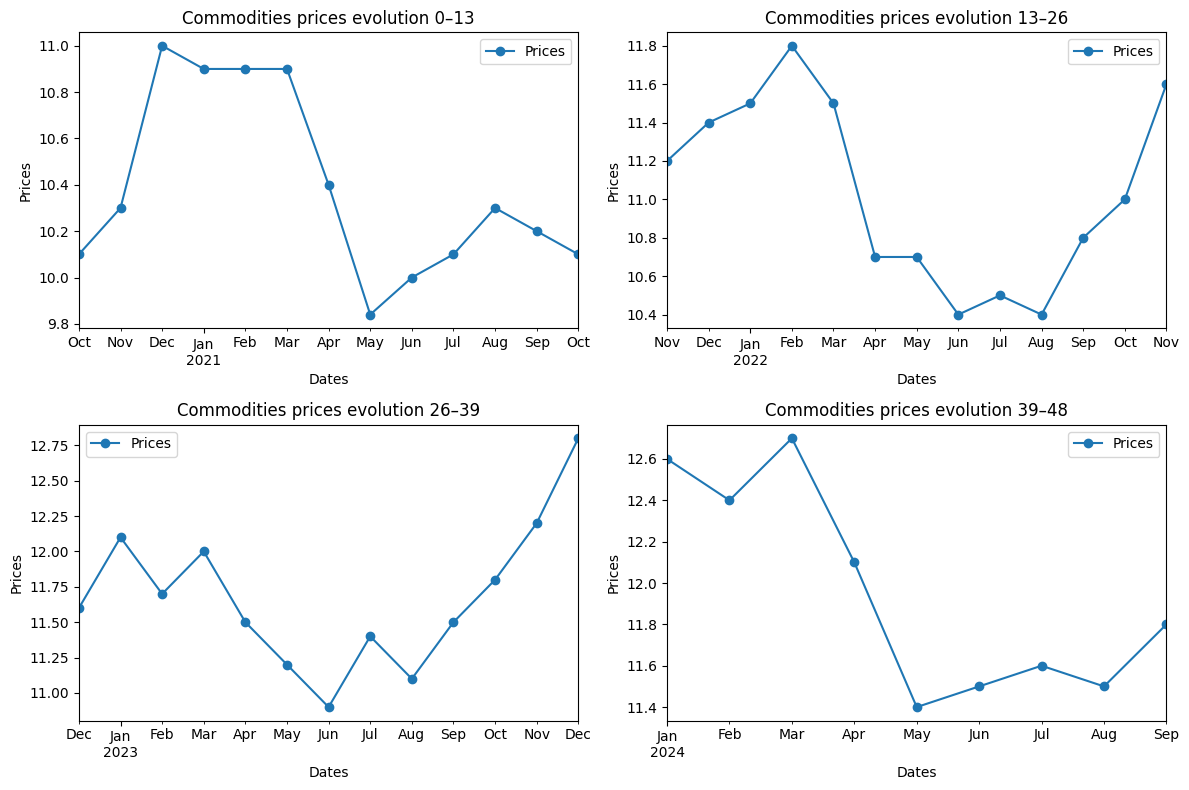

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes = axes.flatten()  # pour avoir une liste d’axes [0,1,2,3]

# Boucle sur les intervalles
for i, (start, end) in enumerate([(0,13), (13,26), (26,39), (39,48)]): 
    subset = data.iloc[start:end, :]
    subset.plot(
        x="Dates", y="Prices", kind="line", marker="o", ax=axes[i]
    )
    axes[i].set_title(f"Commodities prices evolution {start}–{end}")
    axes[i].set_xlabel("Dates")
    axes[i].set_ylabel("Prices")

plt.tight_layout()
plt.show()

#### As we were told in the task's description, data visualization also confirm that there is a seasonality with a period of 12 months. To build the forecasting model, we should therefore take it into account. Still, here we will try two approach, a simple regraession and one that take account seasonality.

### Some preprocessing

In [6]:
data["Dates"] = pd.to_datetime(data.Dates)

/tmp/ipykernel_2571/3953730175.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dates"] = pd.to_datetime(data.Dates)


In [7]:
# organize data in month/year
data['Month'] = [d.month for d in data.Dates]
data['Year']= [d.year for d in data.Dates]

In [8]:
training_data = data.iloc[:35,:]
test_data = data.iloc[35:,:]

### First approach: Simple regression

In [9]:
ols_fit = training_data.groupby('Month')[["Year","Prices"]].apply(lambda x: np.polyfit(x["Year"],x["Prices"],deg = 1))
ols_fit

Month
1      [0.6000000000003747, -1201.700000000758]
2      [0.40000000000020486, -797.333333333748]
3       [0.55000000000034, -1100.6333333340208]
4     [0.5500000000003666, -1101.2333333340748]
5     [0.6800000000004089, -1364.3800000008273]
6      [0.4500000000002873, -899.4666666672476]
7      [0.650000000000432, -1303.6333333342068]
8     [0.40000000000027847, -798.2000000005631]
9     [0.6000000000003879, -1202.4000000007843]
10     [0.4500000000000256, -899.0500000000515]
11    [0.6499999999999843, -1302.6166666666345]
12    [0.29999999999999455, -594.9666666666554]
Name: (Year, Prices), dtype: object

In [10]:
test_data["OLS Prices"] = test_data[["Month","Year"]].apply(lambda x: ols_fit[x.Month][0] * x.Year + ols_fit[x.Month][1] , axis = 1)

/tmp/ipykernel_2571/3585535611.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["OLS Prices"] = test_data[["Month","Year"]].apply(lambda x: ols_fit[x.Month][0] * x.Year + ols_fit[x.Month][1] , axis = 1)


In [11]:
data = data.merge(test_data[["Dates", "OLS Prices"]], on = "Dates", how = 'left')

<Axes: xlabel='Dates'>

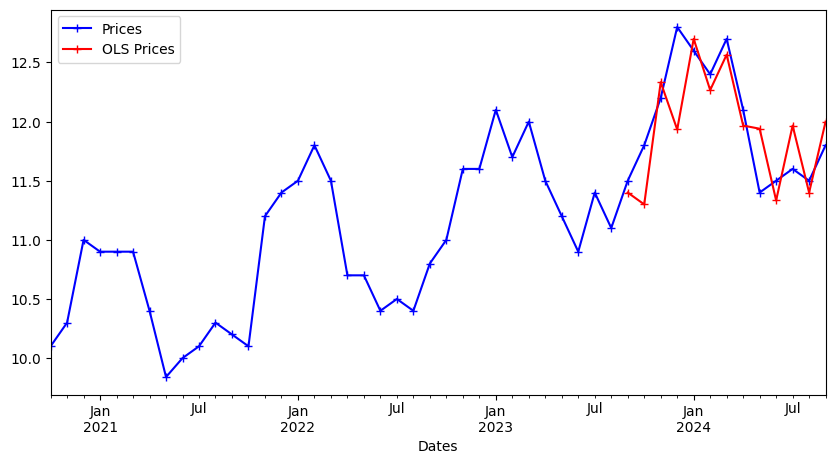

In [12]:
data[["Dates","Prices","OLS Prices"]].set_index("Dates").plot(marker = '+', color = ["b","r"], figsize = (10,5))

In [13]:
# QQ-plot

### Second approach: ANCOVA regression

In [14]:
training_data_ancova = training_data.copy()

training_data_ancova["Month"] = training_data_ancova["Month"].astype("category")
training_data_ancova["Time"] = range(len(training_data_ancova))

test_data_ancova = test_data.copy()

test_data_ancova["Month"] = test_data_ancova["Month"].astype("category")
test_data_ancova["Time"] = range(len(training_data_ancova),  len(data))

model = smf.ols("Prices ~ Time + C(Month)", data=training_data_ancova).fit()


In [15]:
test_data_ancova["ANCOVA Prices"] = model.predict(test_data_ancova[["Prices","Month","Time"]])

In [16]:
data = data.merge(test_data_ancova[["Dates", "ANCOVA Prices"]], on = "Dates", how = 'left')

<Axes: xlabel='Dates'>

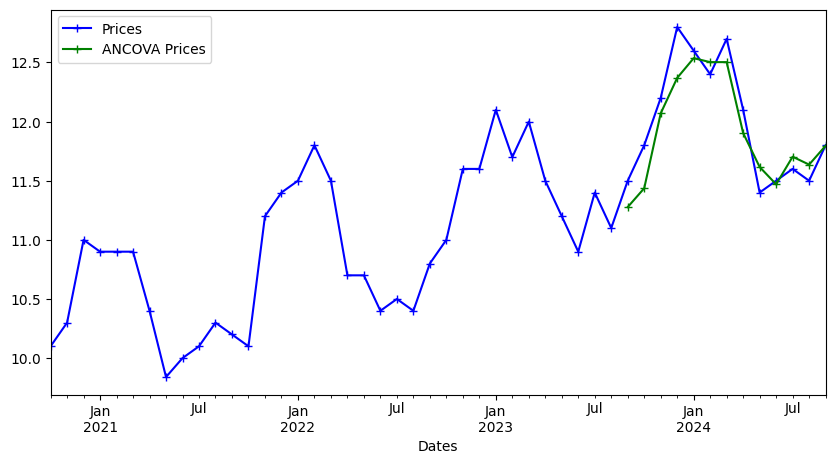

In [17]:
data[["Dates","Prices","ANCOVA Prices"]].set_index("Dates").plot(marker = '+', color = ["b","g"], figsize = (10,5))

#### We see that ANCOVA behaves better than the simple OLS regression during the summer, thanks to its abillity to capture some of the model seasonality. We will therefore use this model for predictions.

### Predictions

In [18]:
data["Time"] = range(len(data))
data["Month"] = data["Month"].astype("category")

model = smf.ols("Prices ~ Time + C(Month)", data=data).fit()

data["ANCOVA Prices"] = model.predict(data[["Prices","Month","Time"]])

In [19]:
# Get the last dates of the twelve next months

future_dates = pd.date_range(data["Dates"].iloc[-1] + pd.offsets.MonthEnd(),
                             periods=12, freq="ME")
future = pd.DataFrame({
    "Dates": future_dates,
    "Time": range(len(data), len(data) + 12),
    "Month": future_dates.month.astype("category")
})
future["Prices"] = model.predict(future)

In [20]:
future_dates

DatetimeIndex(['2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30'],
              dtype='datetime64[ns]', freq='ME')

In [21]:
full_data = pd.concat([data, future], axis = 0, ignore_index=True)

In [22]:
full_data

,Dates,Prices,Month,Year,OLS Prices,ANCOVA Prices,Time
0,2020-10-31,10.10000,10,2020.0,NaN,9.93775,0
1,2020-11-30,10.30000,11,2020.0,NaN,10.51275,1
2,2020-12-31,11.00000,12,2020.0,NaN,10.88775,2
3,2021-01-31,10.90000,1,2021.0,NaN,10.96275,3
4,2021-02-28,10.90000,2,2021.0,NaN,10.88775,4
5,2021-03-31,10.90000,3,2021.0,NaN,10.96275,5
6,2021-04-30,10.40000,4,2021.0,NaN,10.36275,6
7,2021-05-31,9.84000,5,2021.0,NaN,9.97275,7
8,2021-06-30,10.00000,6,2021.0,NaN,9.88775,8
9,2021-07-31,10.10000,7,2021.0,NaN,10.08775,9


Text(0.5, 1.0, 'Natural gas price data from Oct 2020 to Sep 2024 + prediction until Sep 2025')

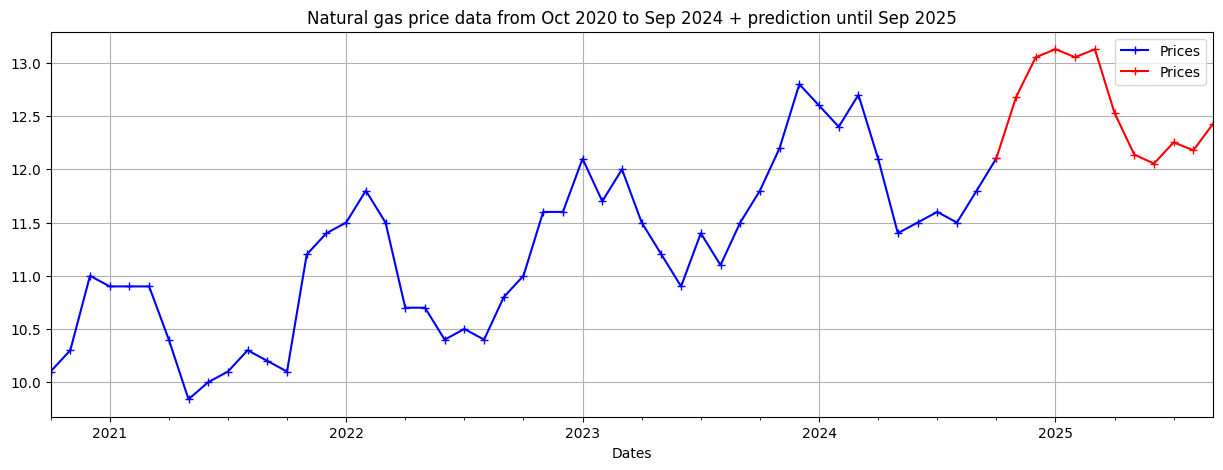

In [23]:
fig, axis = plt.subplots(figsize = (15,5), ncols = 1, nrows = 1)

full_data.loc[range(len(data)+1),["Dates","Prices"]].set_index("Dates").plot(ax = axis, marker = '+', color = ["b"])
full_data.loc[range(len(data), len(full_data)),["Dates","Prices"]].set_index("Dates").plot(ax = axis, marker = '+', color = ["r"], label = 'Predicted')

axis.grid()
axis.set_title('Natural gas price data from Oct 2020 to Sep 2024 + prediction until Sep 2025')